In [1]:
import numpy as np
import json
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from keras import backend as K
from src.learner import *

samples = np.genfromtxt('data/samples.csv', delimiter=",").astype(bool)
holdouts = np.genfromtxt('data/holdouts.csv', delimiter=",").astype(bool)
tests = np.genfromtxt('data/tests.csv', delimiter=",").astype(bool)

2025-02-06 15:34:10.221183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def scale(x, K):
    return K*math.log(x)

The final hyperparameters we settled on were:

Hidden units: 100  
Learning rate: 0.01  
Batch size: 16  
Epochs: 50  

These produced a training and testing accuracy of 0.997 and 0.986, respectively, and were associated with a runtime of under one second. While slightly higher train and test accuracies could have been achieved with more advanced tuning and training (e.g. training on more epochs) this configuration allowed us to achieve near-perfect performance on the training and holdout sets and be able to train within reasonable time horizons.  

100 hidden units is the starting point. The other brute force runs (same words each iteration), we will decrease the number of hidden units by 20 succesively: 100, 80, 60, 40, 20.

This procedure here differs from `brute_force_1` because we write out the test data for every word at the end of training. Not just the aggregate test data for the train and test sets respectively.

In [3]:
with open('data/params.json', 'r') as f:
    cfg = json.load(f)

## Inputs and outputs

In [4]:
X = np.genfromtxt('data/kidwords/orth-kid.csv', delimiter=",")
Y = np.genfromtxt('data/kidwords/phon-kid.csv', delimiter=",")

words = pd.read_csv('data/kidwords/kidwords.csv', header=None)[0].tolist()

In [5]:
X.shape

(2869, 260)

Obtain frequencies for the frequency-weighting operation

In [6]:
elp = pd.read_csv('~/research/words/elp/elp_full_5.27.16.csv')

In [7]:
frequencies = {}

for word in words:
    rowmatch = elp[elp['Word']==word]
    if not rowmatch.empty:
        frequencies[word] = rowmatch['Freq_HAL'].values[0]+1
    else:
        frequencies[word] = 1

In [8]:
frequencies_ = [frequencies[word] for word in words]

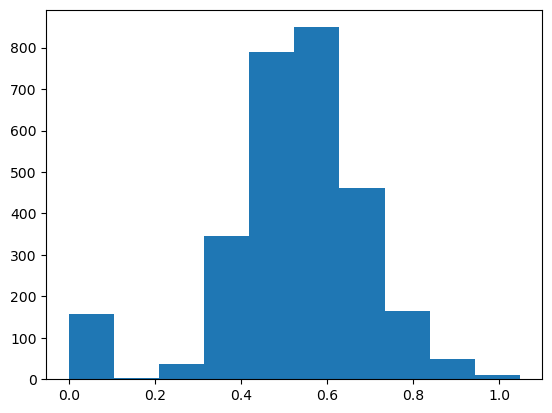

In [11]:
weights = np.array([scale(frequency, cfg["K"]) for frequency in frequencies_])

plt.hist(weights)
plt.show()

## Write frequencies and probabilities to file

In [ ]:
pd.DataFrame({'word': words,
              'frequency': frequencies_,
              'probability': weights.tolist()}).to_csv('word_frequencies_and_probabilities.csv', index=False)

[0.5470039521000558,
 0.4167365938096597,
 0.691548319505963,
 0.6598643840933528,
 0.7196905881627325,
 0.6867617792019002,
 0.619162225732002,
 0.6075526714980031,
 0.4551201322029444,
 0.6182388115073252,
 0.5547716621689471,
 0.698731488181241,
 0.4473125619092643,
 0.0,
 0.886789964095843,
 0.8167762814473631,
 0.8822002936889397,
 1.0006074498292192,
 0.0,
 0.49007021654003124,
 0.510348086174708,
 0.5082419525098062,
 0.921591854965116,
 0.49262391652792575,
 0.6134905620221385,
 0.5845317402501066,
 0.6425894734449064,
 0.682629380702156,
 0.6198840579428377,
 0.9140696884518528,
 0.5060959192465104,
 0.7317990933362715,
 0.7129890740077088,
 0.599952165584191,
 0.6369334892134217,
 0.8961619302509529,
 0.54796343146607,
 0.49165416887621344,
 0.37483141241592766,
 0.4977310726199445,
 0.496357576001126,
 0.41680953158512435,
 0.0,
 0.498201745636589,
 0.7962851220760072,
 0.5462452602583684,
 0.73819080798828,
 0.30367457061213954,
 0.471072037184355,
 0.600019932546068,
 0.53

In [16]:
len(words)

2869

## 100 hidden units

In [ ]:
hidden = 100
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'

        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

## 90 Hidden Units

In [10]:
hidden = 90
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'

        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

2025-01-25 07:25:13.806606: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


90/90 [==============================] - 0s 1ms/step


## 80 Hidden Units

In [ ]:
hidden = 80
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
    pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
    afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
    efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'
    
    with open(PATH + sfn, 'w') as f:
        f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                "hidden_units",
                                                "learning_rate",
                                                "batch_size",
                                                "epochs",
                                                "loss_train",
                                                "accuracy_train",
                                                "mse_train",
                                                "loss_test",
                                                "accuracy_test",
                                                "mse_test",
                                                "loss_holdout",
                                                "accuracy_holdout",
                                                "mse_holdout"))

        model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
        model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

        loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
        loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
        loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

        preds = (model.predict(X) > .5).astype(int)
        np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

        accuracies = (preds == Y).astype(int)
        np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

        mse = K.eval(K.mean(K.square(model.predict(X) - Y), axis = 1))
        np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')
        
        f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    hidden,
                                                    cfg['learning_rate'],
                                                    cfg['batch_size'],
                                                    cfg['epochs'],
                                                    loss_train,
                                                    accuracy_train,
                                                    mse_train,
                                                    loss_test,
                                                    accuracy_test,
                                                    mse_test,
                                                    loss_holdout,
                                                    accuracy_holdout,
                                                    mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

## 70 Hidden Units

In [9]:
hidden = 70
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    if sample > 8029:
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
        efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'
        
        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(model.predict(X) - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')
            
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

8594.5916 seconds elapsed


## 60 Hidden Units

In [ ]:
hidden = 60
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    if sample == 9664:
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
        efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'
        
        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(model.predict(X) - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')
                    
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
    end = time.time()
print(round(end-start, 4), "seconds elapsed")

## 50 Hidden Units

In [ ]:
hidden = 50
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'

        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

## 40 Hidden Units

In [ ]:
hidden = 40
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):

    sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
    pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
    afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
    efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'


    with open(PATH + sfn, 'w') as f:
        f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                "hidden_units",
                                                "learning_rate",
                                                "batch_size",
                                                "epochs",
                                                "loss_train",
                                                "accuracy_train",
                                                "mse_train",
                                                "loss_test",
                                                "accuracy_test",
                                                "mse_test",
                                                "loss_holdout",
                                                "accuracy_holdout",
                                                "mse_holdout"))

        model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
        model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

        loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
        loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
        loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

        preds = (model.predict(X) > .5).astype(int)
        np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

        accuracies = (preds == Y).astype(int)
        np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

        mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
        np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')
        
        f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    hidden,
                                                    cfg['learning_rate'],
                                                    cfg['batch_size'],
                                                    cfg['epochs'],
                                                    loss_train,
                                                    accuracy_train,
                                                    mse_train,
                                                    loss_test,
                                                    accuracy_test,
                                                    mse_test,
                                                    loss_holdout,
                                                    accuracy_holdout,
                                                    mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

## 30 Hidden Units

In [10]:
hidden = 30
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    if sample > 8256:
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
        efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'


        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')
            
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
end = time.time()
print(round(end-start, 4), "seconds elapsed")

6768.444 seconds elapsed


## 20 Hidden Units

In [ ]:
hidden = 20
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    if sample > 5810:
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
        efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'


        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')

            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
        

    

end = time.time()
print(round(end-start, 4), "seconds elapsed")

# 15 hidden units

In [ ]:
hidden = 15
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    if sample > 7709:
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
        efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'

        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')

            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
    

end = time.time()
print(round(end-start, 4), "seconds elapsed")

# 10 hidden units

In [ ]:
hidden = 10
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    if sample > 5136:
        sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
        pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
        afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
        efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'

        with open(PATH + sfn, 'w') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    "hidden_units",
                                                    "learning_rate",
                                                    "batch_size",
                                                    "epochs",
                                                    "loss_train",
                                                    "accuracy_train",
                                                    "mse_train",
                                                    "loss_test",
                                                    "accuracy_test",
                                                    "mse_test",
                                                    "loss_holdout",
                                                    "accuracy_holdout",
                                                    "mse_holdout"))

            model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
            model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

            loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
            loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
            loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

            preds = (model.predict(X) > .5).astype(int)
            np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

            accuracies = (preds == Y).astype(int)
            np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

            mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
            np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')

            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                        hidden,
                                                        cfg['learning_rate'],
                                                        cfg['batch_size'],
                                                        cfg['epochs'],
                                                        loss_train,
                                                        accuracy_train,
                                                        mse_train,
                                                        loss_test,
                                                        accuracy_test,
                                                        mse_test,
                                                        loss_holdout,
                                                        accuracy_holdout,
                                                        mse_holdout))
    

end = time.time()
print(round(end-start, 4), "seconds elapsed")

# 5 hidden units

In [ ]:
hidden = 5
PATH = 'outputs/brute_force_2_with_frequency/'

start = time.time()

for sample in range(samples.shape[1]):
    sfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_summary.csv'
    pfn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_preds.csv'
    afn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_accuracies.csv'
    efn = 'sample_' + str(sample) + '_hidden_' + str(hidden) + '_error.csv'

    with open(PATH + sfn, 'w') as f:
        f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                "hidden_units",
                                                "learning_rate",
                                                "batch_size",
                                                "epochs",
                                                "loss_train",
                                                "accuracy_train",
                                                "mse_train",
                                                "loss_test",
                                                "accuracy_test",
                                                "mse_test",
                                                "loss_holdout",
                                                "accuracy_holdout",
                                                "mse_holdout"))

        model = learner(X, Y, cfg['seed'], hidden, optimizer=Adam(learning_rate=cfg['learning_rate']))
        model.fit(X[samples[:, sample]], Y[samples[:, sample]], epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=False, sample_weight = weights[samples[:, sample]])

        loss_train, accuracy_train, mse_train = model.evaluate(X[samples[:, sample]], Y[samples[:, sample]], verbose=0) 
        loss_test, accuracy_test, mse_test = model.evaluate(X[tests[:, sample]], Y[tests[:, sample]], verbose=0) 
        loss_holdout, accuracy_holdout, mse_holdout = model.evaluate(X[holdouts[:, sample]], Y[holdouts[:, sample]], verbose=0) 

        preds = (model.predict(X) > .5).astype(int)
        np.savetxt(PATH + pfn, preds, fmt='%d', delimiter=',')

        accuracies = (preds == Y).astype(int)
        np.savetxt(PATH + afn, np.mean(accuracies, axis = 1), delimiter=',', fmt='%0.5f')

        mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
        np.savetxt(PATH + efn, mse, delimiter=',', fmt='%0.5f')

        f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(
                                                    hidden,
                                                    cfg['learning_rate'],
                                                    cfg['batch_size'],
                                                    cfg['epochs'],
                                                    loss_train,
                                                    accuracy_train,
                                                    mse_train,
                                                    loss_test,
                                                    accuracy_test,
                                                    mse_test,
                                                    loss_holdout,
                                                    accuracy_holdout,
                                                    mse_holdout))
    

end = time.time()
print(round(end-start, 4), "seconds elapsed")

Generate MSE data for every word for every model after the fact.

In [ ]:
import os

directory = 'outputs/brute_force_2_with_frequency/'
pattern = 'preds'
filenames = []

for filename in os.listdir(directory):
    if pattern in filename:
        filenames.append(filename)

In [ ]:
import numpy as np
from keras import backend as K

for file in filenames:

    outfile = file.replace('preds', 'error')
    preds = np.genfromtxt(directory + file, delimiter=',')
    mse = K.eval(K.mean(K.square(preds - Y), axis = 1))
    np.savetxt(directory + outfile, mse, delimiter=',', fmt='%0.5f')